# Regression Algorithms

As discussed briefly before, Regression is the operation of describing metric of interest, 
$\begin{align*}
y
\end{align*}$
, such that

$\begin{align*}
y = f(x_1, x_2, x_3, ...)
\end{align*}$

__OLS__ as discussed before is a special case when the function described is linear. There are other higher forms of regression that look at describing the trend in a non-linear way.

In [1]:
%matplotlib inline

In [2]:
# Importing datasets
import sklearn
import statsmodels.datasets as dt
from sklearn import datasets
import os
# For data management
import pandas as po

# For visualization
import seaborn as sns
import matplotlib.pyplot as plt

# For random number generation
import numpy as np

# Package to run Regression
import statsmodels.api as sm

# Cross Validation and Hyperparameter Tuning
from statsmodels.sandbox.tools import cross_val
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.metrics import make_scorer

# For Standardization
from scipy.stats.mstats import zscore

sns.set()
sns.set_context('talk')
path = os.getcwd()

C:\Continuum\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


We are using the Boston Massechussets Census Data, which has the following columns:

1. CRIM - per capita crime rate by town
2. ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
3. INDUS - proportion of non-retail business acres per town.
4. CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
5. NOX - nitric oxides concentration (parts per 10 million)
6. RM - average number of rooms per dwelling
7. AGE - proportion of owner-occupied units built prior to 1940
8. DIS - weighted distances to five Boston employment centres
9. RAD - index of accessibility to radial highways
10. TAX - full-value property-tax rate per USD 10,000
11. PTRATIO - pupil-teacher ratio by town
12. B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
13. LSTAT - % lower status of the population
14. MEDV - Median value of owner-occupied homes in USD 1000's

Let us try to predict the value of MEDV. Since we will be describing MEDV as a function of the other variables available to us, the value of MEDV will be __dependent__ on the other variables, which should ideally be varying __independently__. Hence, MEDV is called the dependent variable, and every variable used to form the prediction is called an independent variable.

In [4]:
# boston_data = po.read_csv(path + "/boston_data.csv", index_col = 'Unnamed: 0')
input_raw = dt.get_rdataset("Boston" , "MASS" ).data

In [ ]:
# Getting Boston Dataset
#boston_data = po.read_csv(path + "/boston_data.csv")
#boston_df = po.DataFrame(boston_data)
#boston_df.columns = boston_feature_names
#boston_df['MEDV'] = boston_target
#input_raw = boston_df

In [5]:
# Snapshot of the data
input_raw.''()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [7]:
# Treating Outliers

# Create new column to mark outliers
input_raw['Outliers'] = 0

# Get list of columns
cols = list(input_raw.columns)

# Remove categorical variables
cols.remove('chas')

# Mark values outside 5th and 95th percentile
for col in input_raw.columns:
    input_raw.''[((input_raw[col] < input_raw[col].''(0.05)) | (input_raw[col] > input_raw[col].''(0.95))),'Outliers'] = 1

In [8]:
# Checking number of outliers
input_raw['Outliers'].sum()

249

In [9]:
# Dropping outliers
input_raw1 = input_raw.''(input_raw[input_raw['Outliers']==1].index, axis=0)

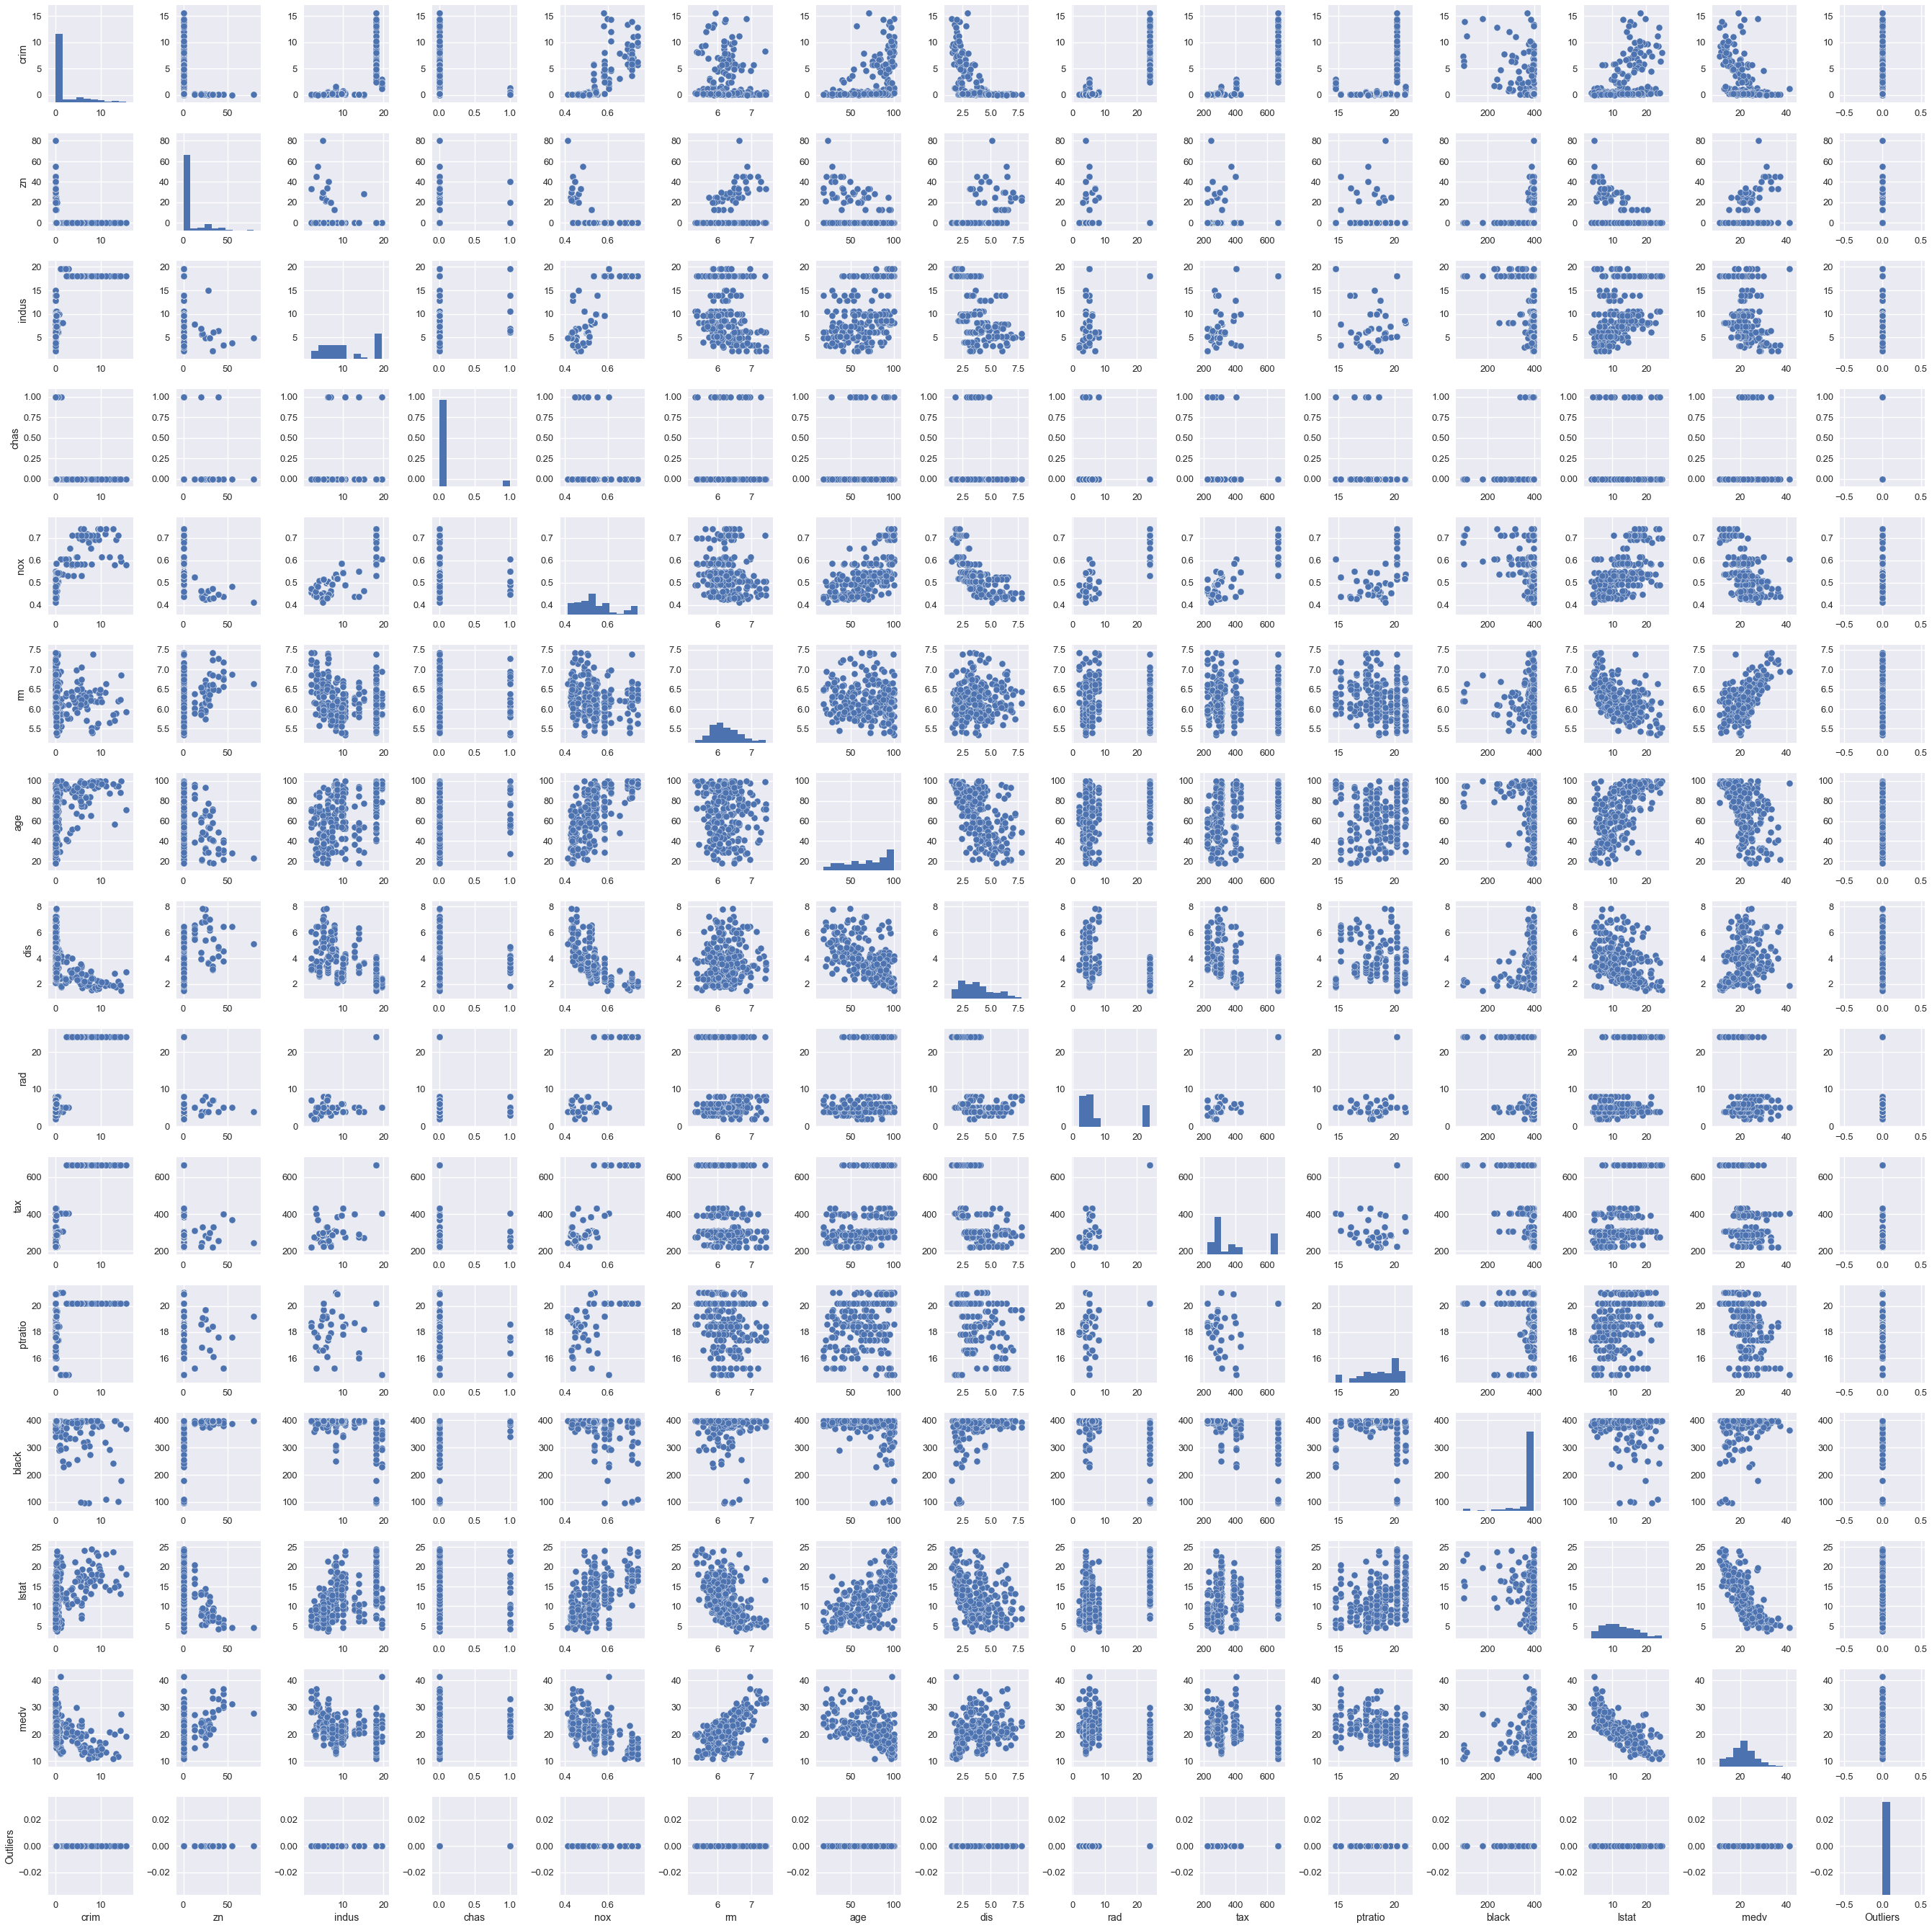

In [10]:
# Pairplot
sns.pairplot(input_raw1)

In [11]:
# Drop Outliers column
del input_raw1['Outliers']

In [12]:
# Creating one-hot encoding for Charles River variable
dummy_chas = po.''(input_raw1['chas'], prefix='chas')

# Merge the dummy columns back to original dataset
input_raw2 = po.''([dummy_chas, input_raw1.''('chas', axis=1)], axis=1)

In [13]:
# Selecting random locations for training datasets
input_raw2['is_train'] = np.random.uniform(0, 1, len(input_raw2)) <= ''
# Filtering data based in train_index locations
train = input_raw2.loc[input_raw2['is_train']==True, :]
# Drop the index
test = input_raw2.loc[input_raw2['is_train']==False, :]

In [14]:
del input_raw2['is_train']
del train['is_train']
del test['is_train']

In [15]:
print(input_raw2.shape)
print(train.shape)
print(test.shape)

(257, 15)
(202, 15)
(55, 15)


### OLS- Ordinary Least Squares model
The linear regression, or the OLS model is one of the most popular regression models. It estimates the value of
$\begin{align*}
y
\end{align*}$
by minimizing the MSE of prediction.

It consists of two major steps:
1. Parameter Estimation
2. Parameter Validation

#### Parameter Estimation
This step is executed to estimated the dependency of
$\begin{align*}
y
\end{align*}$
on
$\begin{align*}
f(x_i).
\end{align*}$

This is done by minimizing

$\begin{align*}
loss = \frac{1}{2n}\sum_{i = 1} ^n (\hat{y} - y)^2
\end{align*}$

But 
$\begin{align*}
\hat{y}
\end{align*}$
is actually
$\begin{align*}
m_1x_1 + m_2x_2 + ...
\end{align*}$
or
$\begin{align*}
\sum m_ix_i
\end{align*}$

So we are actually minimizing

$\begin{align*}
loss = \frac{1}{2n}\sum_{i = 1} ^n (\sum m_ix_i - y)^2
\end{align*}$

by changing 
$\begin{align*}
m_i
\end{align*}$

This step gives us the value of 
$\begin{align*}
m_i
\end{align*}$
for the least loss, which becomes our parameter estimate.

#### Parameter Validation
We now need to validate that the estimated parameter values are correct, given our current data. We use hypothesis testing for this.

The Null Hypothesis is that parameter estimate 
$\begin{align*}
\beta _0
\end{align*}$
equals 0. A low p-value rejects this hypothesis. 

In simplified terms, if 
$\begin{align*}
m_1
\end{align*}$
is 0,
$\begin{align*}
x_1
\end{align*}$
will have no bearing on
$\begin{align*}
y.
\end{align*}$
We try to disprove this by seeking a low p-value. Rule of thumb is taking a threshold of 5%. But this can vary from user to user.

#### Additional validation
The 
$\begin{align*}
\hat{y}
\end{align*}$
value, as generated by 
$\begin{align*}
f(x_i)
\end{align*}$
gives us observation level prediction of the model. When we calculate
$\begin{align*}
\hat{y} - y
\end{align*}$
for each observation, we get the difference between the predicted and actual values of
$\begin{align*}
y.
\end{align*}$
This is also called __residual__ and when aggregated tells us how close or far are the predictions from the actual. We aggregate this into 
$\begin{align*}
R_2
\end{align*}$
value, which basically translates into
$\begin{align*}
R_2
\end{align*}$
closer to 1 representing perfect overlay of actual and predicted values.

In [16]:
# Let's now run the model
model = sm.''(train.loc[:, 'medv'], train.drop('medv', axis=1, inplace=False)).fit()

In [17]:
# View the model summary
model.''()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     50.48
Date:                Tue, 03 Apr 2018   Prob (F-statistic):           3.65e-54
Time:                        11:32:51   Log-Likelihood:                -468.37
No. Observations:                 202   AIC:                             964.7
Df Residuals:                     188   BIC:                             1011.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
chas_0        19.4017      6.348      3.056      0.003       6.880      31.924
chas_1        21.4342      6.308      3.398      0.001       8.991      33.877
crim          -0.1577      0.126     -1.253      0.212      -0.406       0.091
zn             0.0238      0.018      1.295      0.197      -0.012       0.060
indus          0.0783      0.067      1.163      0.246      -0.054       0.211
nox          -14.9535      4.824     -3.100      0.002     -24.469      -5.438
rm             4.9076      0.621      7.902      0.000       3.683       6.133
age           -0.0557      0.013     -4.341      0.000      -0.081      -0.030
dis           -1.0962      0.208     -5.266      0.000      -1.507      -0.686
rad            0.0616      0.091      0.680      0.498      -0.117       0.240
tax           -0.0032      0.004     -0.712      0.477      -0.012       0.006
ptratio       -0.6473      0.134     -4.836      0.000      -0.911      -0.383
black          0.0069      0.004      1.807      0.072      -0.001       0.014
lstat         -0.2614      0.068     -3.822      0.000      -0.396      -0.126
==============================================================================
Omnibus:                       48.820   Durbin-Watson:                   1.499
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              116.807
Skew:                           1.074   Prob(JB):                     4.32e-26
Kurtosis:                       6.044   Cond. No.                     2.90e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.9e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [18]:
# Building a dataframe for parameter values
model_params_values = po.DataFrame(model.'', columns=['Params'])
# Dropping params with p < 0.05
model_params_values = model_params_values.''(model.pvalues[model.pvalues > 0.05].index, axis=0)

# Sort parameters by their absolute values
model_params_values['abs'] = np.''(model_params_values['Params'])
model_params_values = model_params_values.''(['abs'], ascending=False)

([<matplotlib.axis.XTick at 0xc4286433c8>,
 <a list of 8 Text xticklabel objects>)

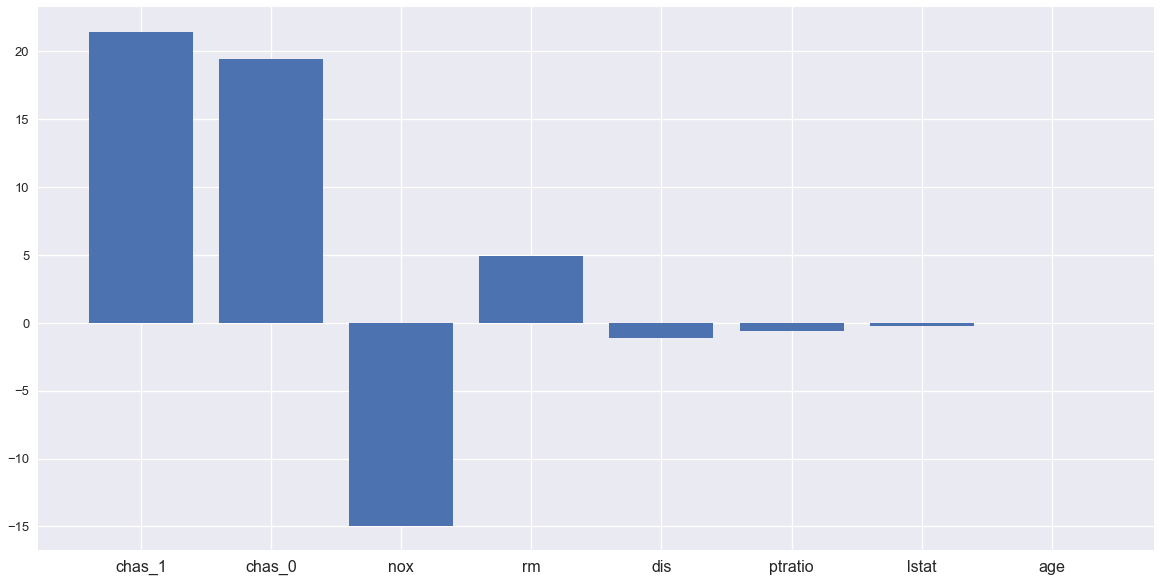

In [19]:
# Plotting parameter values on a bar chart
fig = plt.figure(figsize=[20,10])
plt.''(range(model_params_values.shape[0]), model_params_values['Params'])

# Renaming x-axis with parameter names
plt.xticks(range(model_params_values.shape[0]), model_params_values.index, fontsize=16)

In [20]:
# Standardization
input_raw3 = po.DataFrame(''(input_raw2), columns=input_raw2.columns)

In [21]:
# Selecting random locations for training datasets
input_raw3['is_train'] = np.random.uniform(0, 1, len(input_raw3)) <= .8
# Filtering data based in train_index locations
train = input_raw3.loc[input_raw3['is_train']==True, :]
# Drop the index
test = input_raw3.loc[input_raw3['is_train']==False, :]

In [22]:
del input_raw3['is_train']
del train['is_train']
del test['is_train']

In [23]:
# Let's now run the model
model = sm.OLS(train.loc[:, 'medv'], train.''('medv', axis=1, inplace=False)).''()

In [24]:
# Let's view the summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     55.02
Date:                Tue, 03 Apr 2018   Prob (F-statistic):           9.66e-59
Time:                        11:41:49   Log-Likelihood:                -139.68
No. Observations:                 213   AIC:                             305.4
Df Residuals:                     200   BIC:                             349.1
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
chas_0        -0.0409      0.021     -1.977      0.049      -0.082   -9.74e-05
chas_1         0.0409      0.021      1.977      0.049    9.74e-05       0.082
crim           0.0312      0.078      0.403      0.687      -0.122       0.184
zn             0.0076      0.041      0.184      0.854      -0.074       0.089
indus          0.0615      0.067      0.925      0.356      -0.070       0.193
nox           -0.2631      0.078     -3.382      0.001      -0.417      -0.110
rm             0.3842      0.048      8.013      0.000       0.290       0.479
age           -0.2315      0.055     -4.231      0.000      -0.339      -0.124
dis           -0.3106      0.056     -5.559      0.000      -0.421      -0.200
rad            0.1051      0.135      0.778      0.437      -0.161       0.371
tax           -0.2151      0.130     -1.655      0.100      -0.471       0.041
ptratio       -0.1972      0.044     -4.513      0.000      -0.283      -0.111
black          0.0882      0.036      2.469      0.014       0.018       0.159
lstat         -0.2662      0.062     -4.304      0.000      -0.388      -0.144
==============================================================================
Omnibus:                       46.774   Durbin-Watson:                   1.445
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              112.713
Skew:                           0.983   Prob(JB):                     3.35e-25
Kurtosis:                       5.972   Cond. No.                     7.01e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.61e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [25]:
# Dataframe containing model parameters
model_params_values = po.DataFrame(model.params, columns=['Params'])
model_params_values = model_params_values.drop(model.pvalues[model.pvalues > 0.05].index, axis=0)
model_params_values['abs'] = np.abs(model_params_values['Params'])
model_params_values = model_params_values.sort_values(['abs'], ascending=False)

([<matplotlib.axis.XTick at 0xc4307f28d0>,
 <a list of 9 Text xticklabel objects>)

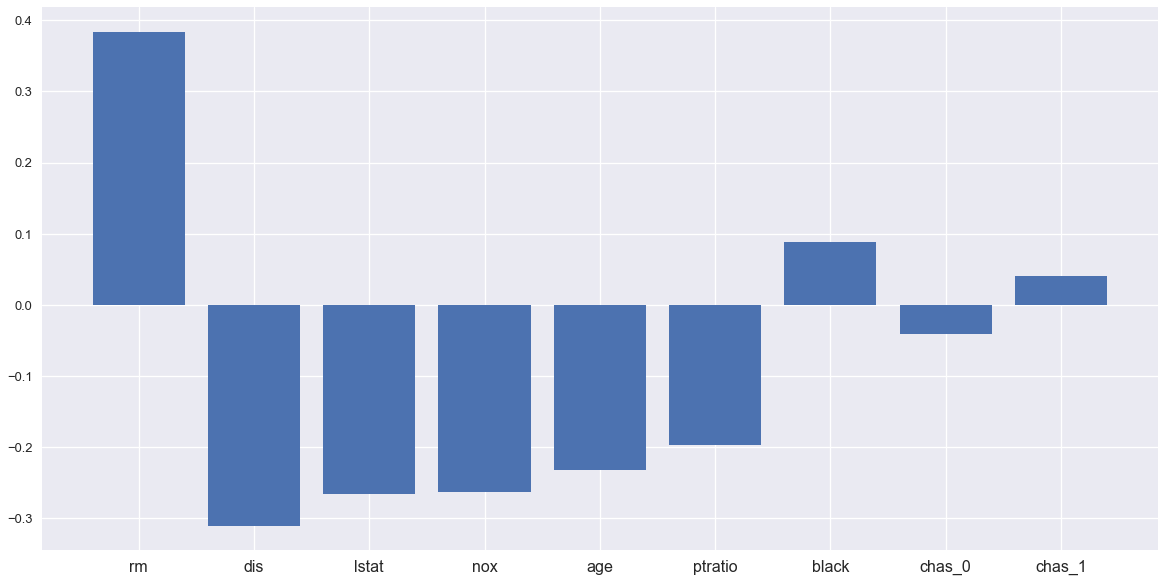

In [26]:
# Plotting the parameters
fig = plt.figure(figsize=[20,10])
plt.bar(range(model_params_values.shape[0]), model_params_values['Params'])
plt.xticks(range(model_params_values.shape[0]), model_params_values.index, fontsize=16)

In [27]:
# K-Fold CrossValidation
kf = cross_val.KFold(input_raw3.shape[0], k=10)

In [28]:
# Defining Error Score Calculation
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [29]:
tuned_parameters = [{'alpha':[0.1, 0.2, 0.3, 0.5, 0.7, 1.0]}]
model = GridSearchCV(linear_model.''(alpha=1.), tuned_parameters, cv=10, scoring=''(mean_absolute_percentage_error))
model.fit(input_raw2'', input_raw2'')

GridSearchCV(cv=10, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'alpha': [0.1, 0.2, 0.3, 0.5, 0.7, 1.0]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_percentage_error), verbose=0)

In [30]:
model.cv_results_['mean_test_score']

array([ 10.88051171,  11.15396005,  11.52729655,  12.68656236,
        12.85530684,  13.04605419])

In [31]:
# Let's now run the model
reg_model = sm.OLS(train'', train'').''(alpha=0.1)

In [32]:
# Let's view the summary
reg_model.''

chas_0     0.000000
chas_1     0.000000
crim       0.000000
zn         0.000000
indus      0.000000
nox       -0.102867
rm         0.266879
age       -0.026220
dis        0.000000
rad        0.000000
tax        0.000000
ptratio   -0.154016
black      0.000000
lstat     -0.377955
dtype: float64

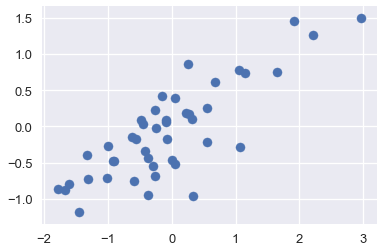

In [33]:
plt.''(test['medv'], reg_model.predict(test.drop('medv', axis=1)))

In [34]:
cv_model = {}
count = 0
for train_index, test_index in kf:
    X_train, X_test, y_train, y_test = cross_val.split(train_index, test_index, input_raw3.drop('medv', axis=1, inplace=False), input_raw3['medv'])
    cv_model[count] = sm.OLS(y_train, X_train).fit_regularized(alpha=0.1)
    count+=1

In [35]:
cv_model_p = {}
for i in range(len(cv_model.keys())):
    cv_model_p[i] = po.Series(cv_model[i].params)
    cv_model_p[i].index = input_raw3.drop('medv', axis=1, inplace=False).columns

In [36]:
cv_model_df = po.DataFrame(cv_model_p).T

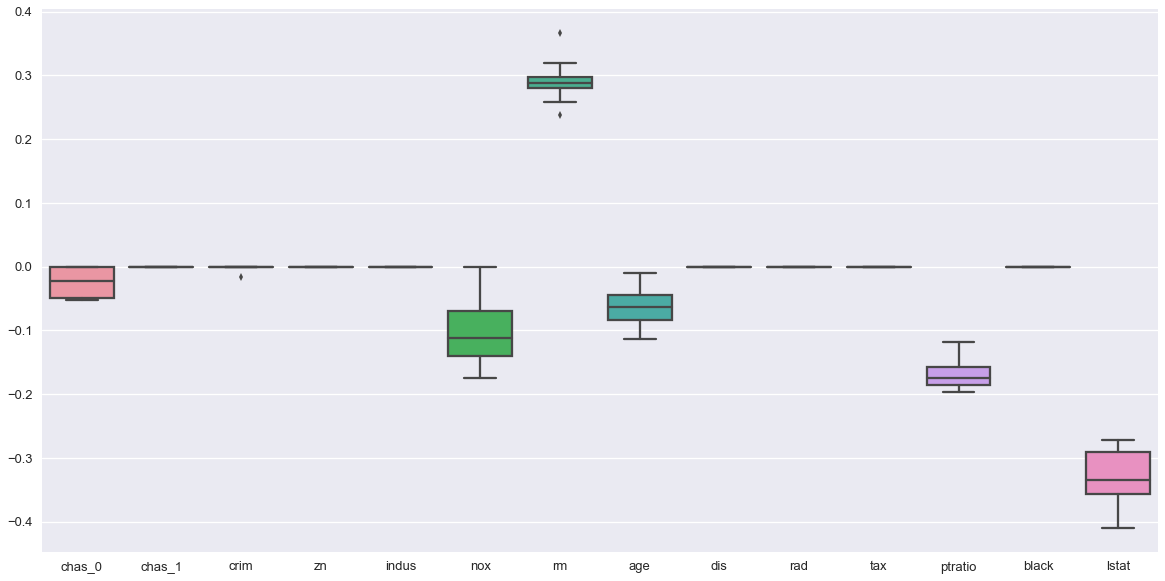

In [37]:
fig = plt.figure(figsize=[20,10])
sns.''(data=cv_model_df)

### Other regression models
What we covered so far was the Linear Regression model. But regression can also be conducted by other algorithms like the following:
1. Decision Trees
2. Random Forest
3. Ensemble Models
4. Splines Models
5. Neural Networks
6. Support Vector Machines

Each model has their own area of use and places where they are useful. Let's look at some of them

### Decision trees

In [39]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import model_selection

X = input_raw2.drop('medv', axis = 1)
y = input_raw2['medv']

#Creating training and test sets

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size = 0.2, 
                                                                             random_state = 33)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

model = DecisionTreeRegressor(criterion = 'mse', max_depth = 3, random_state=33)

model.fit(X_train, y_train)

(205, 14)
(52, 14)
(205,)
(52,)


DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=33, splitter='best')

Mean squared error: 15.6035477223


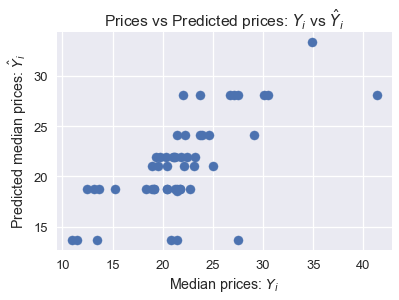

In [40]:
y_pred = model.predict(X_test)


#Plotting predicted vs. actuals
plt.scatter(y_test, y_pred)
plt.xlabel("Median prices: $Y_i$")
plt.ylabel("Predicted median prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$")

#Calculating the error
mse = sklearn.metrics.mean_squared_error(y_test, y_pred)
print('Mean squared error:', mse)

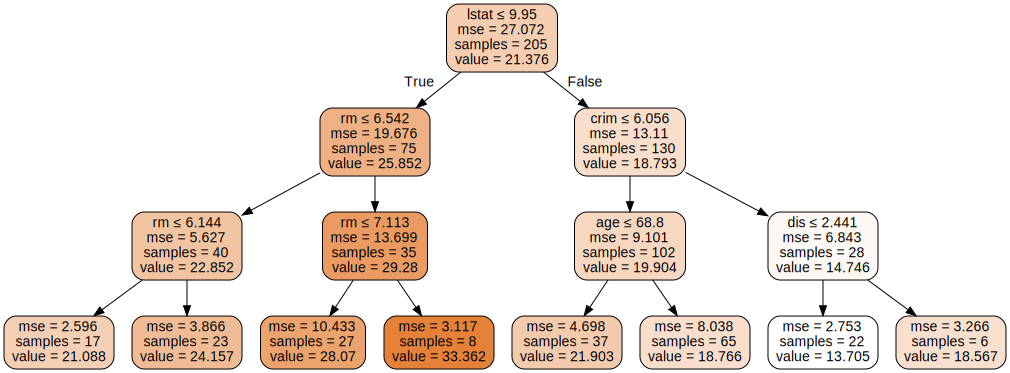

In [41]:
#Visualising the tree
from sklearn import tree
import graphviz 

dot_data = tree.export_graphviz(model, out_file=None,
                                feature_names = X_train.columns,
                                
                         filled=True, rounded=True,  
                         special_characters=True,
                               max_depth=5)  
graph = graphviz.Source(dot_data)  
graph 

Text(0,0.5,'Importance')

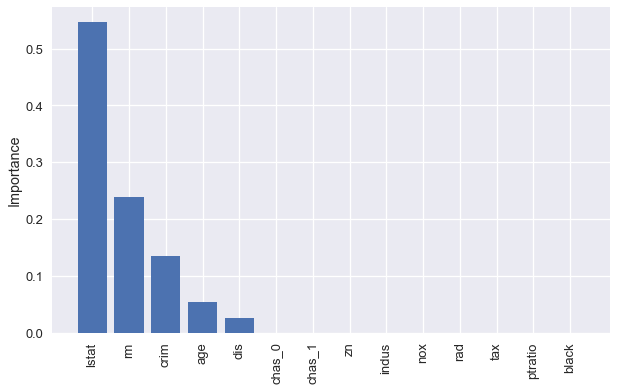

In [42]:
sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))
labels, importances = zip(*sorted(zip(X_test.columns, model.feature_importances_), reverse=True, key=lambda x: x[1]))
plt.xticks(range(len(labels)), labels)
_, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.bar(range(len(importances)), importances)
plt.ylabel('Importance')

## Random Forests

In [43]:
from sklearn.ensemble import RandomForestRegressor

X = input_raw2.drop('medv', axis = 1)
y = input_raw2['medv']

#Creating training and test sets

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size = 0.2, 
                                                                             random_state = 33)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

model = RandomForestRegressor(criterion = 'mse', max_depth = 3, random_state=33, n_estimators = 100)

model.fit(X_train, y_train)

(205, 14)
(52, 14)
(205,)
(52,)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=33, verbose=0, warm_start=False)

Mean squared error: 11.2227700461


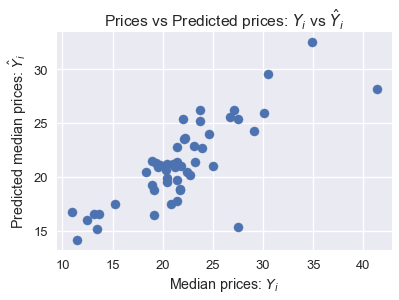

In [44]:
y_pred = model.predict(X_test)


#Plotting predicted vs. actuals
plt.scatter(y_test, y_pred)
plt.xlabel("Median prices: $Y_i$")
plt.ylabel("Predicted median prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$")

#Calculating the error
mse = sklearn.metrics.mean_squared_error(y_test, y_pred)
print('Mean squared error:', mse)

Text(0,0.5,'Importance')

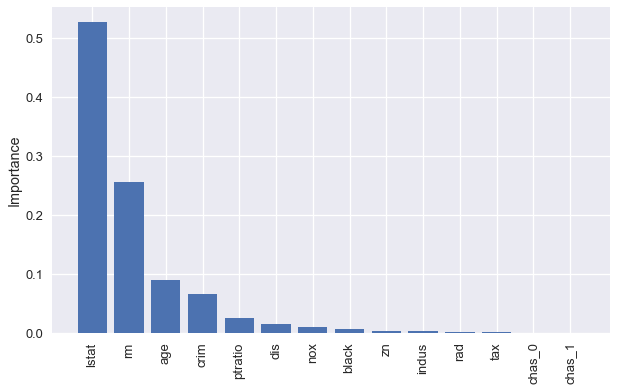

In [45]:
sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))
labels, importances = zip(*sorted(zip(X_test.columns, model.feature_importances_), reverse=True, key=lambda x: x[1]))
plt.xticks(range(len(labels)), labels)
_, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.bar(range(len(importances)), importances)
plt.ylabel('Importance')

### Field Work

For today's session there are 3 simple steps to practice. In your selected data set do the following:

1. Using your previous dataset, try different algorithms and compare to your linear model. Did you see an improvement or not? Why do you think that is the case?
2. Select the model you decided to use and implement a GridSearch to tune hyperparameters of the model
3. Apply the tuned model and produce predicted vs. actual dataset. What error improvement did you get? Why do you think that is happening?